# Imports, creating the databunch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [3]:
# path = Path("D:/Datasets/state-farm-distracted-driver-detection")
path = Path("C:/state-farm-distracted-driver-detection")
img_path = path/"imgs"

In [4]:
img_path.ls()

[WindowsPath('C:/state-farm-distracted-driver-detection/imgs/models'),
 WindowsPath('C:/state-farm-distracted-driver-detection/imgs/test'),
 WindowsPath('C:/state-farm-distracted-driver-detection/imgs/train')]

In [5]:
path.ls()

[WindowsPath('C:/state-farm-distracted-driver-detection/driver_imgs_list.csv'),
 WindowsPath('C:/state-farm-distracted-driver-detection/imgs'),
 WindowsPath('C:/state-farm-distracted-driver-detection/preds.pt'),
 WindowsPath('C:/state-farm-distracted-driver-detection/sample_submission.csv'),
 WindowsPath('C:/state-farm-distracted-driver-detection/submissions')]

In [6]:
bs=48

In [7]:
labels = ["safe driving",
         "texting - right",
         "talking on the phone - right",
         "texting - left",
         "talking on the phone - left",
         "operating the radio",
         "drinking",
         "reaching behind",
         "hair and makeup",
         "talking to passenger"]

labels_dict = {}
for i in range(10):
    labels_dict[("c"+str(i))] = labels[i]
    
rev_labels_dict = {}
for i in labels_dict.keys():
    rev_labels_dict[labels_dict[i]] = i
    
def func(x):
    return labels_dict[str(x.parent)[-2:]]

In [8]:
np.random.seed(42)
data = (ImageList.from_folder(img_path, exclude="test")
        .split_by_rand_pct(0.1)
        .label_from_func(func)
        .add_test_folder("test")
        .transform(get_transforms(), size=112)
        .databunch(bs=bs)).normalize(imagenet_stats)

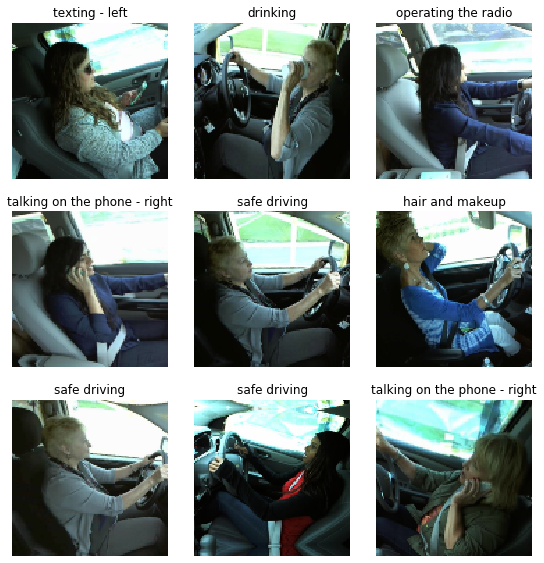

In [9]:
data.show_batch(rows=3, figsize=(8,8))

# Resnet-34 as baseline

### Yesterday

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy]).to_fp16()

In [11]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.576419,1.041863,0.340767,0.659233,03:01
1,0.918524,0.456335,0.136931,0.863069,03:07
2,0.580307,0.255165,0.079393,0.920607,03:09
3,0.415085,0.141578,0.040143,0.959857,03:08
4,0.321394,0.099526,0.029438,0.970562,03:06
5,0.268506,0.080331,0.020963,0.979037,03:05
6,0.227561,0.072724,0.020963,0.979037,03:05
7,0.241162,0.071778,0.018733,0.981267,03:03


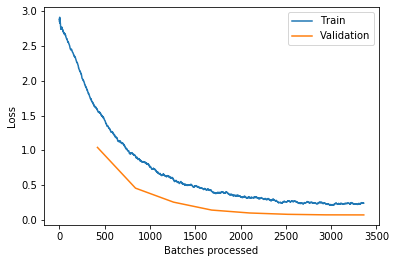

In [12]:
learn.recorder.plot_losses()

In [13]:
learn.save("rsn34-fr-0.018")
# learn.load("rsn34-fr-0.044");

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


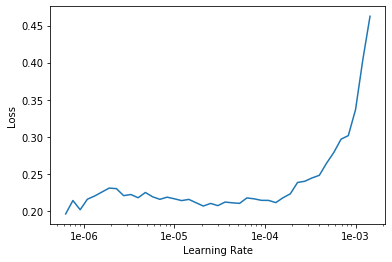

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.203853,0.064089,0.016949,0.983051,03:00
1,0.142075,0.046995,0.013827,0.986173,03:08
2,0.106970,0.038164,0.012043,0.987957,03:10
3,0.112889,0.036244,0.010705,0.989295,03:10


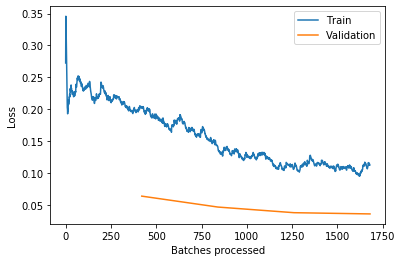

In [20]:
learn.recorder.plot_losses()

In [37]:
# learn.save("rsn34-unfr-0.010")
learn.load("rsn34-unfr-0.010");

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


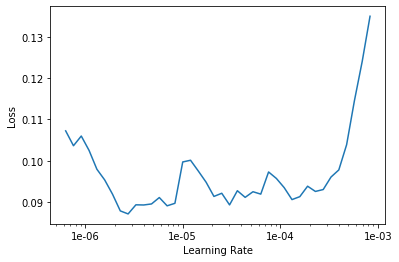

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(4, max_lr=slice(2e-8, 2e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.097887,0.036735,0.010705,0.989295,03:02
1,0.108375,0.037319,0.012043,0.987957,03:06
2,0.107528,0.035016,0.011151,0.988849,03:09
3,0.108991,0.035722,0.010705,0.989295,03:10


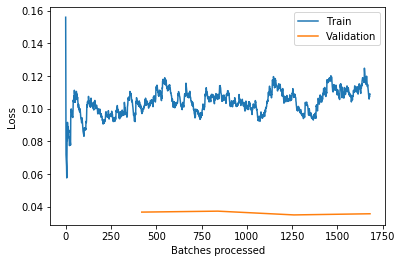

In [26]:
learn.recorder.plot_losses()

### 06.04.2020 05:12PM Continue Training

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


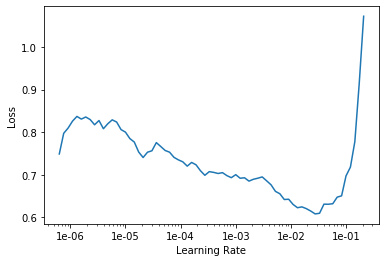

In [33]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.232692,0.080033,0.023863,0.976137,04:18
1,0.192468,0.059248,0.016280,0.983720,04:33
2,0.132682,0.058469,0.018510,0.981490,04:39
3,0.098224,0.032452,0.008698,0.991302,04:42
4,0.065862,0.030060,0.007583,0.992417,04:42


In [39]:
learn.save("rsn34-unfr-0.007")
# learn.load("rsn34-unfr-0.007")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


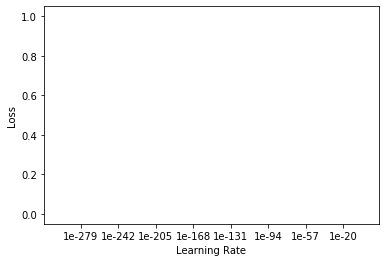

In [40]:
learn.lr_find()
learn.recorder.plot()

## Error does not improve

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


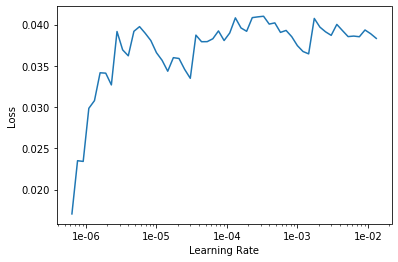

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.039952,0.019198,0.005129,03:28
1,0.034940,0.019171,0.004683,03:32
2,0.031956,0.019334,0.005352,03:30


# Resnet-50

In [15]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


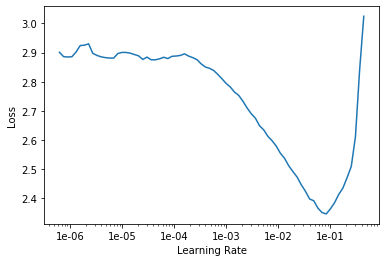

In [46]:
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.986399,0.499100,0.157003,03:39
1,0.449149,0.191698,0.053747,03:44
2,0.255200,0.122681,0.030107,03:42
3,0.212433,0.101542,0.023417,03:42


In [48]:
learn.save("rsn50-fr-0.023")

In [49]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.249955,0.108742,0.028546,03:37
1,0.173874,0.090421,0.023417,03:42


In [50]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,0.163969,0.082315,0.021186,03:29
1,0.140628,0.072767,0.018064,03:43
2,0.131073,0.074392,0.016949,03:43
3,0.149611,0.070718,0.017395,03:47
4,0.159118,0.071874,0.017395,03:50
5,0.124823,0.065426,0.017618,03:51
6,0.115281,0.060558,0.012935,03:50
7,0.111404,0.056928,0.012712,03:52
8,0.100888,0.056324,0.010928,03:54
9,0.088255,0.044020,0.010036,03:56


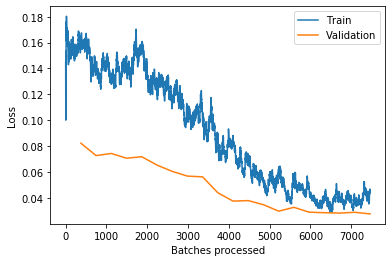

In [51]:
learn.recorder.plot_losses()

In [12]:
# learn.save("rsn50-fr-0.006")
learn.load("rsn50-fr-0.006");

In [56]:
# learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


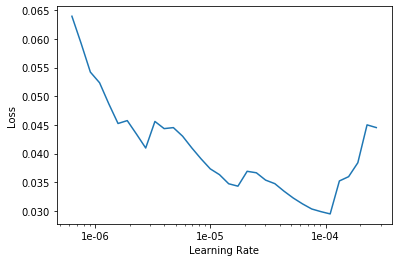

In [57]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.040143,0.007325,0.001338,04:23
1,0.048584,0.007863,0.001338,04:23
2,0.045552,0.007725,0.001338,03:59


In [16]:
# learn.save("rsn50-unfr-0.001")
learn.load("rsn50-unfr-0.001");

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

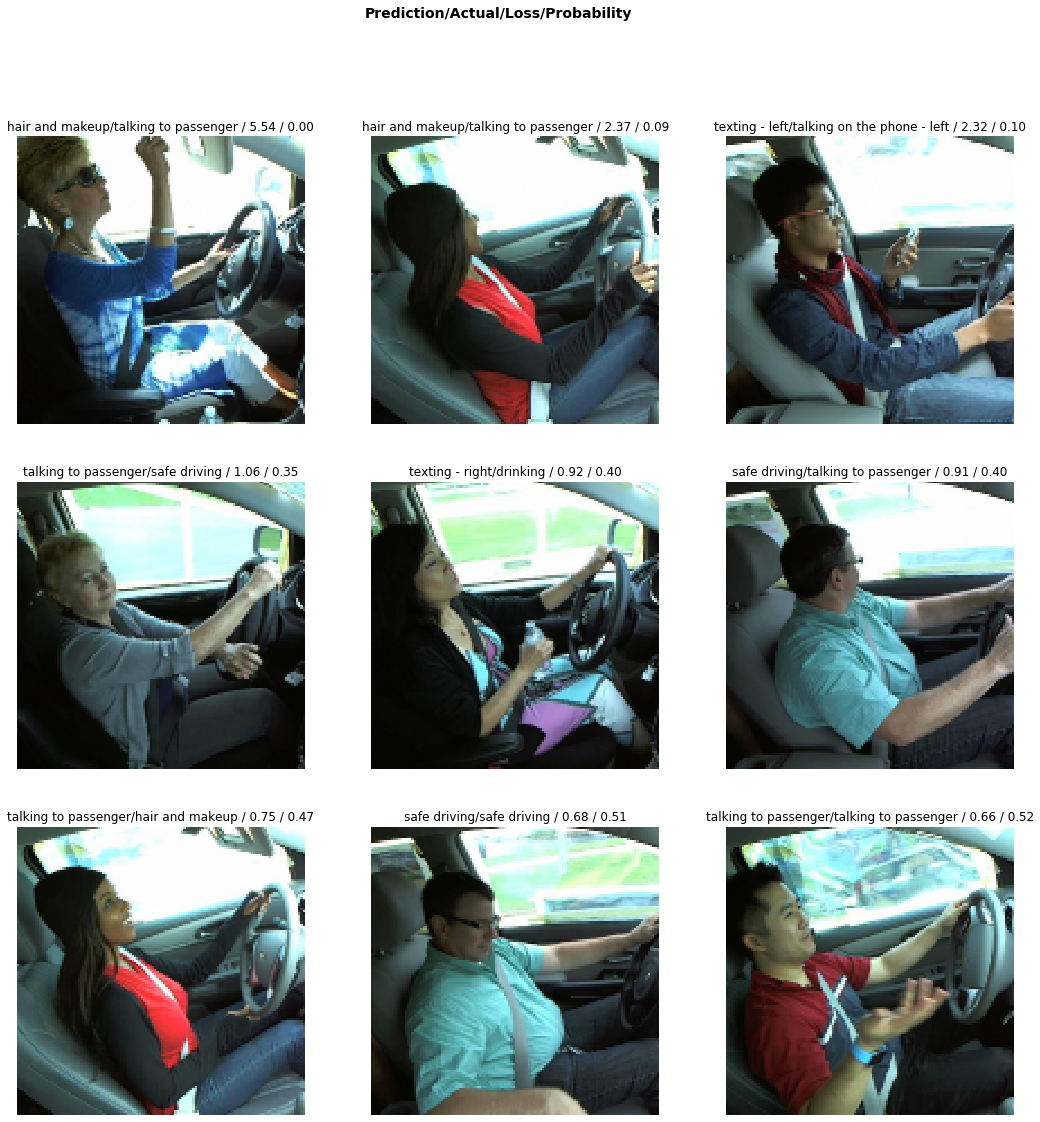

In [39]:
interp.plot_top_losses(9, figsize=(18,18))

### Training with a larger image size

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


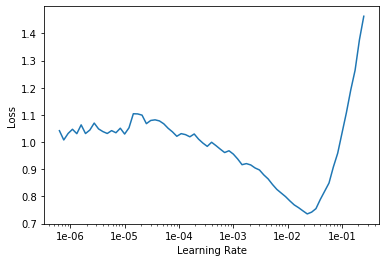

In [53]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(8, max_lr=slice(8e-3, 8e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.188378,0.068992,0.019848,06:17
1,0.191212,0.129654,0.031222,06:34
2,0.161366,0.069448,0.022302,06:44
3,0.135958,0.052688,0.018287,06:54


KeyboardInterrupt: 

### Calculating metric

In [28]:
preds, targs = learn.get_preds(ds_type=DatasetType.Valid)

In [29]:
targs_one_hot = torch.zeros((len(targs), 10))
for i in range(len(targs)):
    targs_one_hot[i][targs[i]] = 1.
    
preds = torch.clamp(preds, min=1e-15, max=1-1e-15)
for p in preds:
    torch.div(p, p.sum(), out=p)

In [30]:
mulclas_loss = 0
for i in range(len(preds)):
    mulclas_loss += (torch.dot(targs_one_hot[i], log(preds[i]))).sum()
mulclas_loss /= -len(preds)

In [31]:
mulclas_loss

tensor(0.0362)

# Creating submission file

In [38]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
# torch.save(preds, path/'preds.pt')
# preds = torch.load(path/'preds.pt')
preds = preds.numpy()

In [39]:
from tqdm import tqdm_notebook as tqdm

test_files = [i.name for i in data.test_ds.x.items]
res_dict = {}
for i in tqdm(range(len(test_files))):
    res_dict[test_files[i]] = preds[i]

In [40]:
cols = [rev_labels_dict[i] for i in data.classes]
res = pd.DataFrame.from_dict(res_dict, orient="index", columns=cols)

In [41]:
res = (res[sorted(cols)]).reset_index().rename(columns={"index":"img"})

In [42]:
res.to_csv(path/"submissions"/"rsn34-unfr-0.010.csv", index=False)